# US Household Income Bracket Classification

## Import Libraries

In [1]:
import pandas as pd
import plotly.express as px
from copy import copy
from scipy import stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,accuracy_score,roc_curve,confusion_matrix
import xgboost

In [34]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Load the Data

In [2]:
columns = ['Age','Workclass','fnlgwt','Education','Education num','Marital Status',
           'Occupation','Relationship','Race','Sex','Capital Gain','Capital Loss',
           'Hours/Week','Native country','Income']

income_df = pd.read_csv('data.csv', names = columns)

In [3]:
income_df

,Age,Workclass,fnlgwt,Education,Education num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours/Week,Native country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [4]:
# Goal: Find whether the person has income above or below 50k
income_df['Income'] = income_df['Income'].apply(lambda x: 1 if x == ' >50K' else 0)

In [5]:
income_df.head()

,Age,Workclass,fnlgwt,Education,Education num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours/Week,Native country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


## EDA and Data Cleaning

In [6]:
# Getting dataframe info
income_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       32561 non-null  object
 2   fnlgwt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education num   32561 non-null  int64 
 5   Marital Status  32561 non-null  object
 6   Occupation      32561 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital Gain    32561 non-null  int64 
 11  Capital Loss    32561 non-null  int64 
 12  Hours/Week      32561 non-null  int64 
 13  Native country  32561 non-null  object
 14  Income          32561 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 3.7+ MB


In [7]:
# Obtain the statistical summary of the dataframe
income_df.describe()

,Age,fnlgwt,Education num,Capital Gain,Capital Loss,Hours/Week,Income
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456,0.240810
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429,0.427581
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


In [8]:
# Check for null values
income_df.isnull().sum()

Age               0
Workclass         0
fnlgwt            0
Education         0
Education num     0
Marital Status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital Gain      0
Capital Loss      0
Hours/Week        0
Native country    0
Income            0
dtype: int64

In [9]:
# Get the number of unique values in the workclass
income_df['Workclass'].value_counts()

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: Workclass, dtype: int64

In [10]:
income_df.Workclass.mode()[0]

' Private'

In [11]:
# Replace the values '?' with mode() since it is a categorical variable
# The mode of a set of values is the value that appears most often. 

income_df.Workclass.replace(' ?', income_df.Workclass.mode()[0], inplace = True)

In [12]:
income_df['Workclass'].value_counts()

 Private             24532
 Self-emp-not-inc     2541
 Local-gov            2093
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: Workclass, dtype: int64

In [13]:
# Get the number of unique values in the occupation
income_df['Occupation'].value_counts()

 Prof-specialty       4140
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical         3770
 Sales                3650
 Other-service        3295
 Machine-op-inspct    2002
 ?                    1843
 Transport-moving     1597
 Handlers-cleaners    1370
 Farming-fishing       994
 Tech-support          928
 Protective-serv       649
 Priv-house-serv       149
 Armed-Forces            9
Name: Occupation, dtype: int64

In [14]:
# Replace the values '?' with mode() since it is a categorical variable
# The mode of a set of values is the value that appears most often. 
income_df.Occupation.replace(' ?', income_df.Occupation.mode()[0], inplace = True)

In [15]:
income_df.Occupation.mode()[0]

' Prof-specialty'

In [16]:
# Get the number of unique values in the native country
income_df['Native country'].value_counts()

 United-States                 29170
 Mexico                          643
 ?                               583
 Philippines                     198
 Germany                         137
 Canada                          121
 Puerto-Rico                     114
 El-Salvador                     106
 India                           100
 Cuba                             95
 England                          90
 Jamaica                          81
 South                            80
 China                            75
 Italy                            73
 Dominican-Republic               70
 Vietnam                          67
 Guatemala                        64
 Japan                            62
 Poland                           60
 Columbia                         59
 Taiwan                           51
 Haiti                            44
 Iran                             43
 Portugal                         37
 Nicaragua                        34
 Peru                             31
 

In [17]:
# Replace '?' with 'other'
income_df['Native country'].replace(' ?',' other', inplace = True)

In [18]:
# Get the correlation
income_df.corr()

,Age,fnlgwt,Education num,Capital Gain,Capital Loss,Hours/Week,Income
Age,1.000000,-0.076646,0.036527,0.077674,0.057775,0.068756,0.234037
fnlgwt,-0.076646,1.000000,-0.043195,0.000432,-0.010252,-0.018768,-0.009463
Education num,0.036527,-0.043195,1.000000,0.122630,0.079923,0.148123,0.335154
Capital Gain,0.077674,0.000432,0.122630,1.000000,-0.031615,0.078409,0.223329
Capital Loss,0.057775,-0.010252,0.079923,-0.031615,1.000000,0.054256,0.150526
Hours/Week,0.068756,-0.018768,0.148123,0.078409,0.054256,1.000000,0.229689
Income,0.234037,-0.009463,0.335154,0.223329,0.150526,0.229689,1.000000


In [19]:
income_df['Marital Status'].value_counts()

 Married-civ-spouse       14976
 Never-married            10683
 Divorced                  4443
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse           23
Name: Marital Status, dtype: int64

## Data Visualization

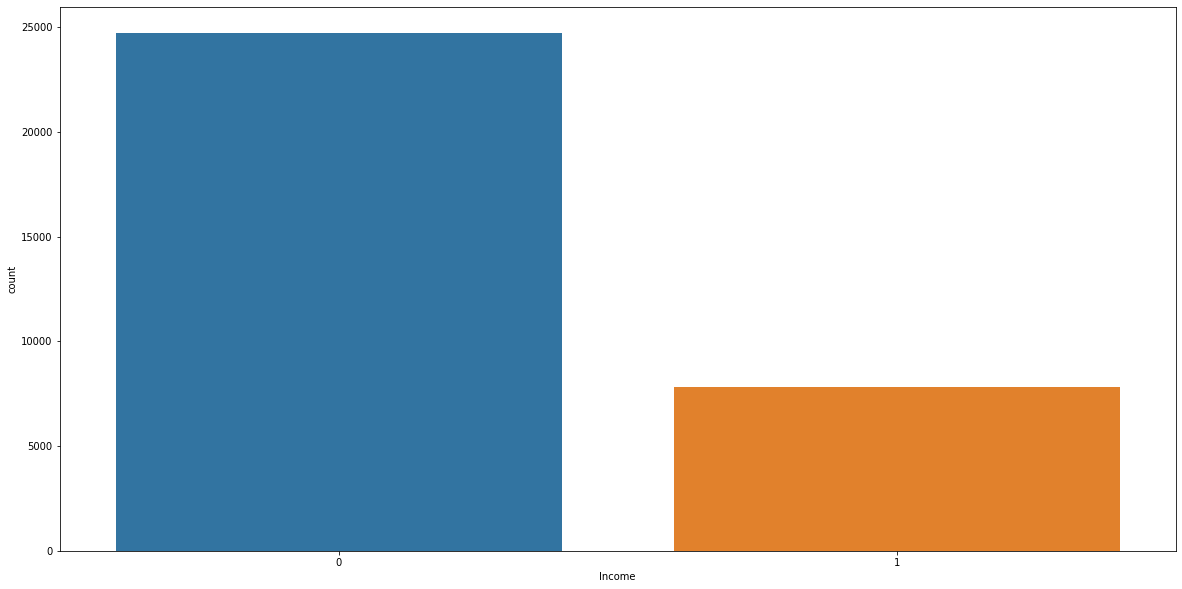

In [32]:
# Visualize the income countplot
plt.figure(figsize = (20, 10))
sns.countplot(x='Income', data=income_df);

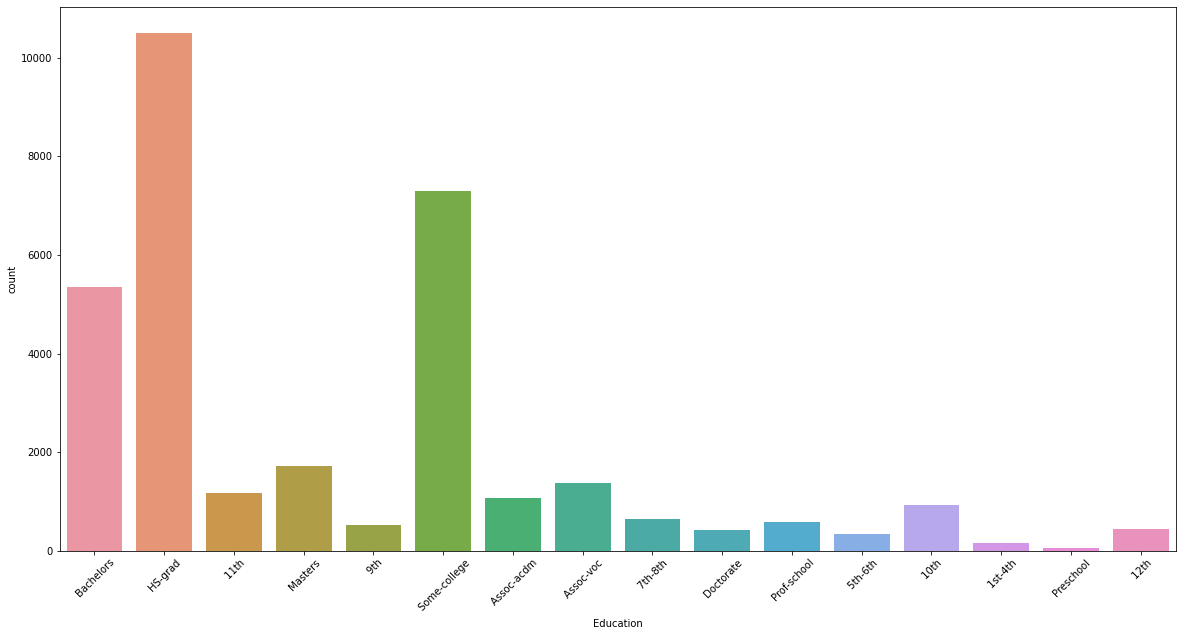

In [31]:
# Visualize the Education levels
plt.figure(figsize = (20, 10))
sns.countplot(x='Education', data=income_df);
plt.xticks(rotation = 45);

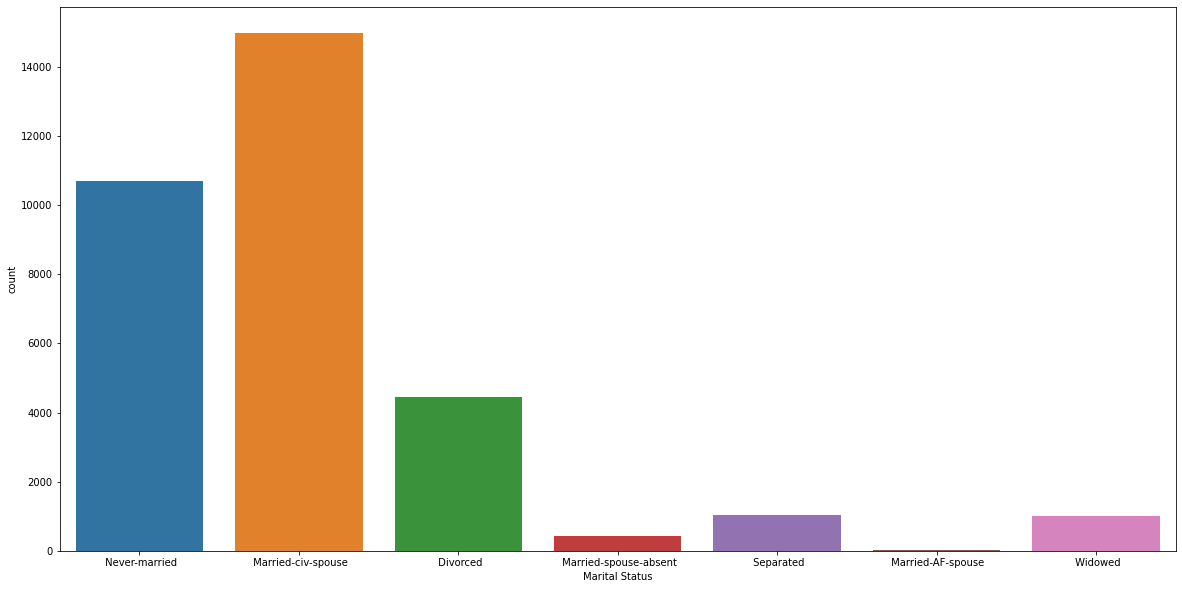

In [39]:
# Visualize the MArital Statuses
plt.figure(figsize = (20, 10))
sns.countplot(income_df['Marital Status']);

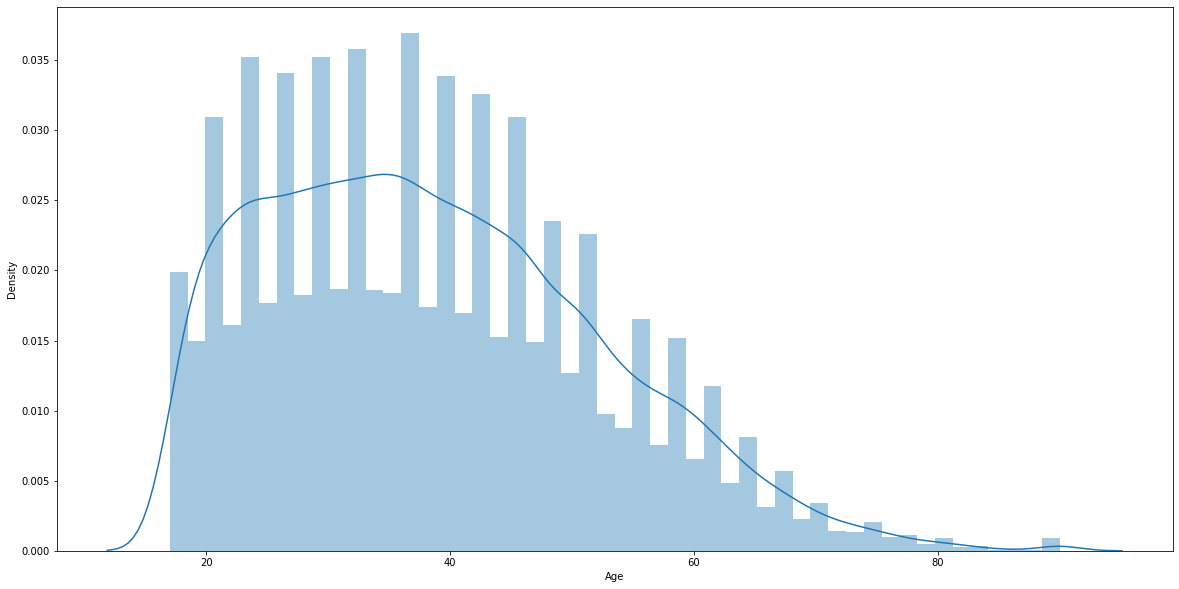

In [35]:
# Visualize the Age distributuion
plt.figure(figsize = (20,10))
sns.distplot(income_df['Age']);

<Figure size 1440x1440 with 0 Axes>

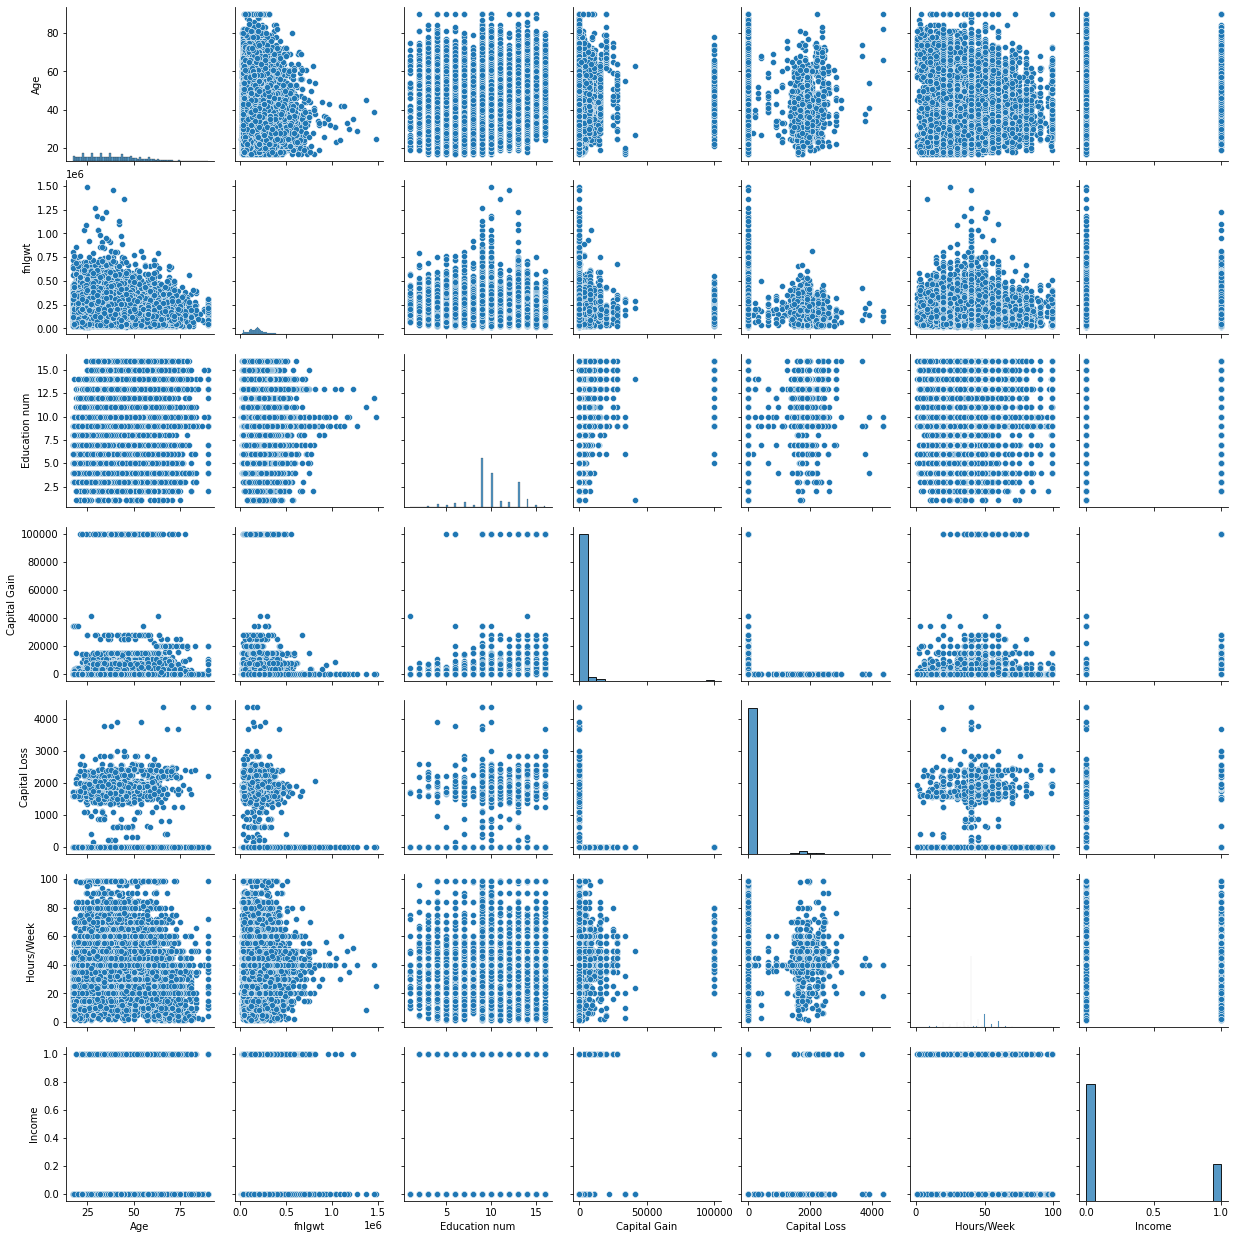

In [36]:
# Plot pairplot
plt.figure(figsize = (20, 20))
sns.pairplot(income_df);

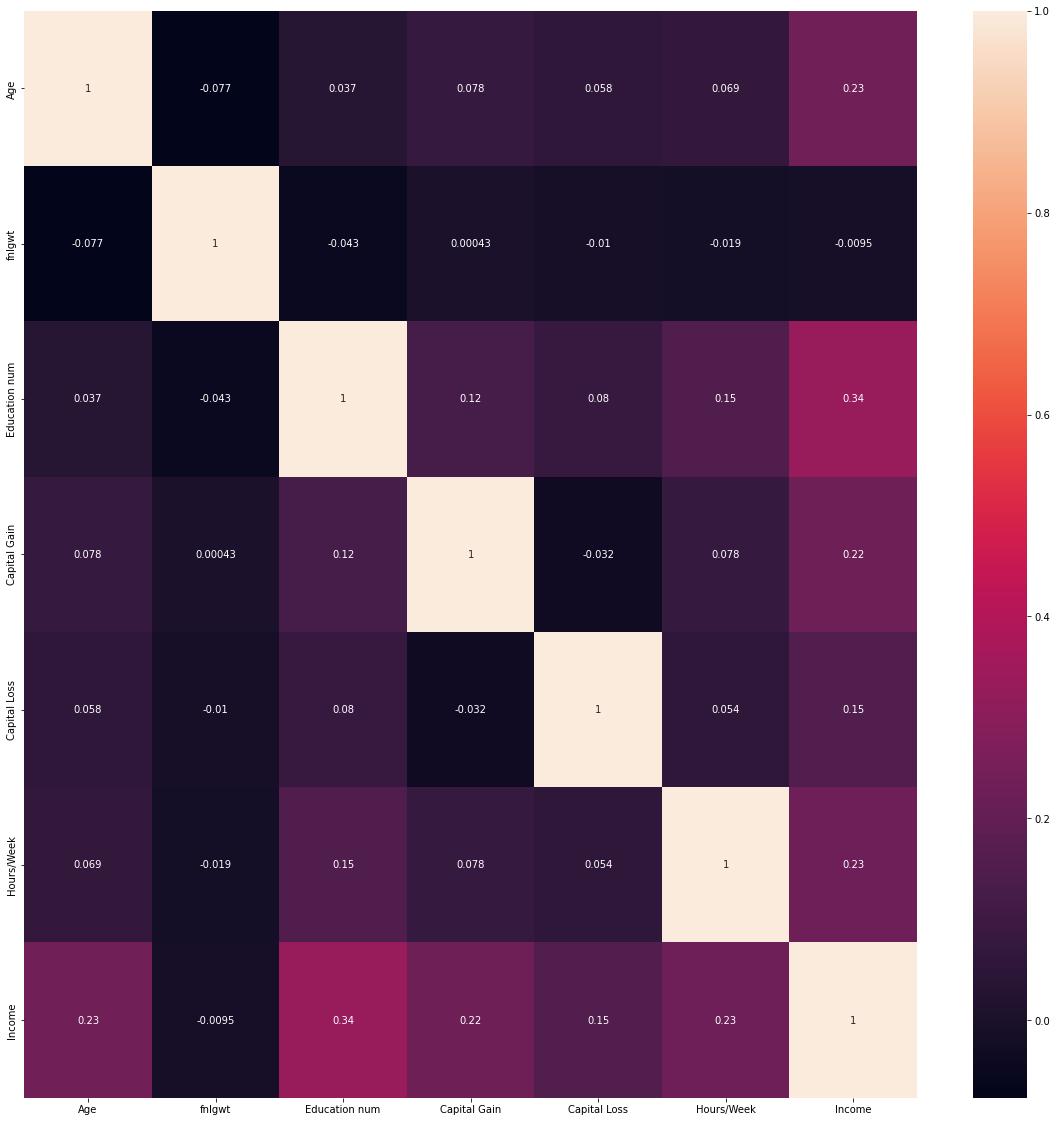

In [37]:
# Correlation plot
plt.figure(figsize = (20,20))
cm = income_df.corr()
sns.heatmap(cm, annot = True);

## Data Preprocessing

In [40]:
income_df.columns

Index(['Age', 'Workclass', 'fnlgwt', 'Education', 'Education num',
       'Marital Status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Capital Gain', 'Capital Loss', 'Hours/Week', 'Native country',
       'Income'],
      dtype='object')

In [41]:
X = income_df.drop(columns = ['Income'])
X

,Age,Workclass,fnlgwt,Education,Education num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours/Week,Native country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States


In [42]:
y = income_df['Income']
y

0        0
1        0
2        0
3        0
4        0
        ..
32556    0
32557    1
32558    0
32559    0
32560    1
Name: Income, Length: 32561, dtype: int64

In [43]:
# LabelEncoder to encode categorical variables

encode = LabelEncoder()
for i in X.columns:
    X[i] = encode.fit_transform(X[i])

In [44]:
X.head()

,Age,Workclass,fnlgwt,Education,Education num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours/Week,Native country
0,22,6,2671,9,12,4,0,1,4,1,25,0,39,38
1,33,5,2926,9,12,2,3,0,4,1,0,0,12,38
2,21,3,14086,11,8,0,5,1,4,1,0,0,39,38
3,36,3,15336,1,6,2,5,0,2,1,0,0,39,38
4,11,3,19355,9,12,2,9,5,2,0,0,0,39,4


In [45]:
# Perform One-hot encoding
features = ['Workclass','Education','Marital Status','Occupation','Relationship','Race','Sex','Native country']

X = pd.get_dummies(X, columns = features)
X.head()

,Age,fnlgwt,Education num,Capital Gain,Capital Loss,Hours/Week,Workclass_0,Workclass_1,Workclass_2,Workclass_3,...,Native country_32,Native country_33,Native country_34,Native country_35,Native country_36,Native country_37,Native country_38,Native country_39,Native country_40,Native country_41
0,22,2671,12,25,0,39,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,33,2926,12,0,0,12,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,21,14086,8,0,0,39,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,36,15336,6,0,0,39,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,11,19355,12,0,0,39,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [46]:
# Scale the data before training the model
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler_x = StandardScaler()
X = scaler_x.fit_transform(X)

## Train Test Split

In [47]:
# Split the data into testing and training sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [48]:
# print input/output shapes
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((26048, 106), (6513, 106), (26048,), (6513,))

## Build and Assess a Logistic Regressor

In [49]:
lr = LogisticRegression()

In [50]:
lr.fit(X_train, y_train)
print('TRAINING ACCURACY:', lr.score(X_train, y_train))

TRAINING ACCURACY: 0.8501996314496314


In [51]:
predicted = lr.predict(X_test)
print('TEST ACCURACY: ', accuracy_score(y_test, predicted))

TEST ACCURACY:  0.8464609243052357


In [52]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      4934
           1       0.73      0.58      0.65      1579

    accuracy                           0.85      6513
   macro avg       0.80      0.76      0.77      6513
weighted avg       0.84      0.85      0.84      6513



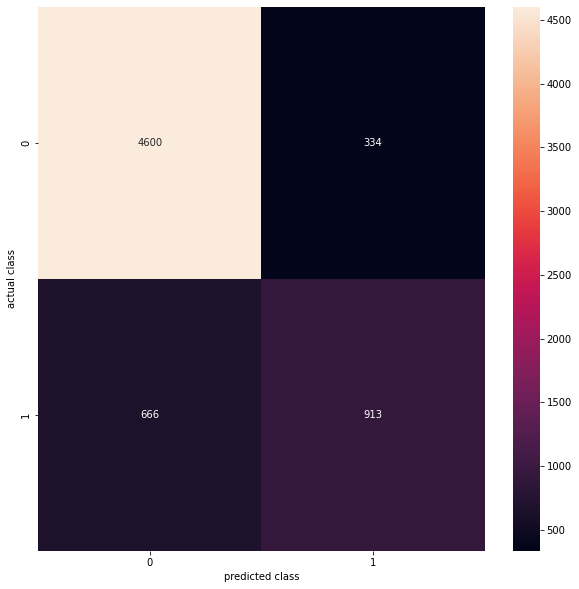

In [53]:
plt.figure(figsize = (10, 10))
cm = confusion_matrix(y_test, predicted) 
sns.heatmap(cm, annot = True,fmt = '.5g')
plt.ylabel('actual class')
plt.xlabel('predicted class');

In [61]:
lr = LogisticRegression(solver = 'liblinear', penalty = 'l1')
lr.fit(X_train, y_train)
print('TRAINING ACCUARACY:', lr.score(X_train, y_train))

TRAINING ACCUARACY: 0.8502380221130221


In [62]:
predicted = lr.predict(X_test)
print('TEST ACCURACY: ', accuracy_score(y_test, predicted))

TEST ACCURACY:  0.8466144633809305


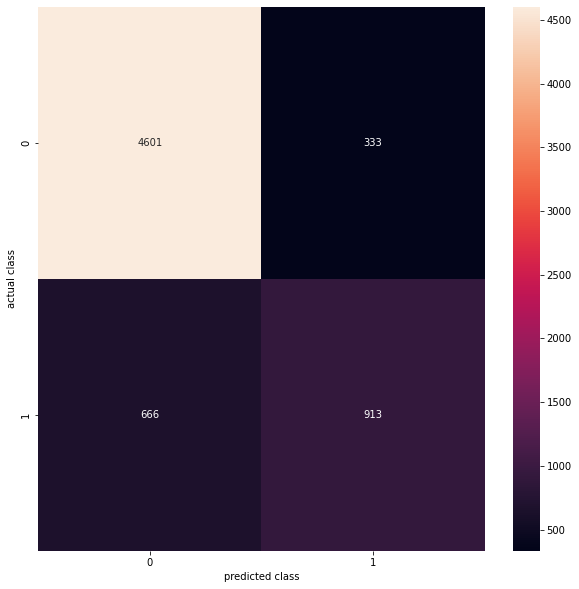

In [65]:
plt.figure(figsize = (10, 10))
cm = confusion_matrix(y_test, predicted) 
sns.heatmap(cm, annot = True,fmt = '.5g')
plt.ylabel('actual class')
plt.xlabel('predicted class');

In [64]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      4934
           1       0.73      0.58      0.65      1579

    accuracy                           0.85      6513
   macro avg       0.80      0.76      0.77      6513
weighted avg       0.84      0.85      0.84      6513



## Build and Assess a XGBoost Classifier

In [66]:
xgb = xgboost.XGBClassifier(learning_rate = 0.01)

In [67]:
xgb.fit(X_train, y_train)

[11:01:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [68]:
predicted = xgb.predict(X_test)

In [69]:
predicted

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [70]:
print('TEST ACCURACY: ', accuracy_score(y_test, predicted))

TEST ACCURACY:  0.8535237217871948


In [71]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      4934
           1       0.79      0.54      0.64      1579

    accuracy                           0.85      6513
   macro avg       0.83      0.75      0.78      6513
weighted avg       0.85      0.85      0.84      6513



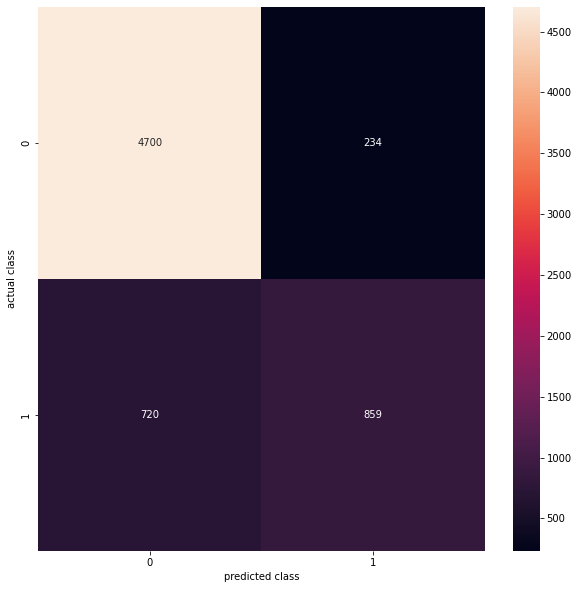

In [72]:
plt.figure(figsize = (10,10))
cm = confusion_matrix(y_test, predicted) 
sns.heatmap(cm, annot = True,fmt = '.5g')
plt.ylabel('actual class')
plt.xlabel('predicted class');